# PRCP-1016-HeartDiseasePred
## Team ID -  PTID-CDS-NOV-25-3300
### Muhammed Sayees

### Section 0 - Imports, config, and reproducibility

In [16]:
import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot style
sns.set(style="whitegrid", context="notebook")

DATA_DIR = Path("data")


### Section 1 – Load values.csv and labels.csv

In [3]:
values = pd.read_csv(DATA_DIR / "values.csv")
labels = pd.read_csv(DATA_DIR / "labels.csv")

print("Values shape:", values.shape)
print("Labels shape:", labels.shape)

display(values.head())
display(labels.head())

Values shape: (180, 14)
Labels shape: (180, 2)


,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


### Section 2 Merge and quick sanity checks

In [6]:
df = values.merge(labels, on="patient_id", how="inner")
df.set_index("patient_id", inplace=True)

target_col = "heart_disease_present"  # adjust if your label column name differs
X = df.drop(columns=[target_col])
y = df[target_col]

print("Merged shape:", df.shape)
print("Target distribution (proportion):")
print(y.value_counts(normalize=True))

display(df.head())
df.info()

Merged shape: (180, 14)
Target distribution (proportion):
heart_disease_present
0    0.555556
1    0.444444
Name: proportion, dtype: float64


,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   slope_of_peak_exercise_st_segment     180 non-null    int64  
 1   thal                                  180 non-null    object 
 2   resting_blood_pressure                180 non-null    int64  
 3   chest_pain_type                       180 non-null    int64  
 4   num_major_vessels                     180 non-null    int64  
 5   fasting_blood_sugar_gt_120_mg_per_dl  180 non-null    int64  
 6   resting_ekg_results                   180 non-null    int64  
 7   serum_cholesterol_mg_per_dl           180 non-null    int64  
 8   oldpeak_eq_st_depression              180 non-null    float64
 9   sex                                   180 non-null    int64  
 10  age                                   180 non-null    int64  
 11  max_heart_rate_a

### Section 3 – Exploratory Data Analysis (EDA)

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
count,180.000000,180,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.550000,NaN,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667,0.444444
std,0.618838,NaN,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474,0.498290
min,1.000000,NaN,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000,0.000000
25%,1.000000,NaN,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000,0.000000
50%,1.000000,NaN,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000,0.000000
75%,2.000000,NaN,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000,1.000000


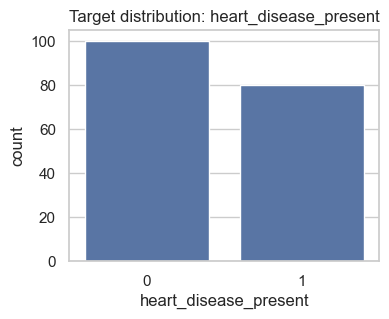

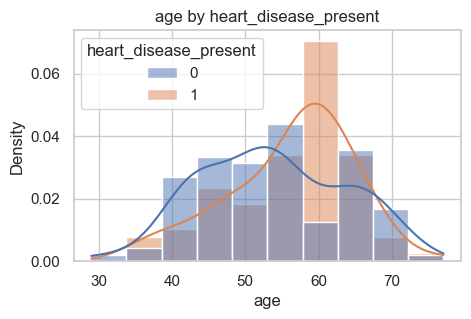

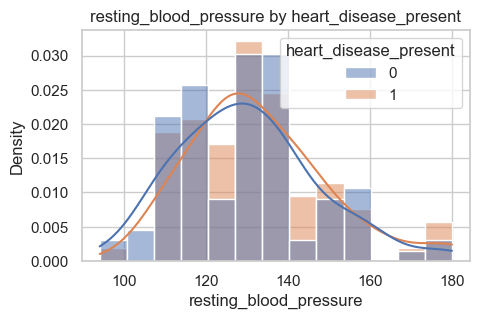

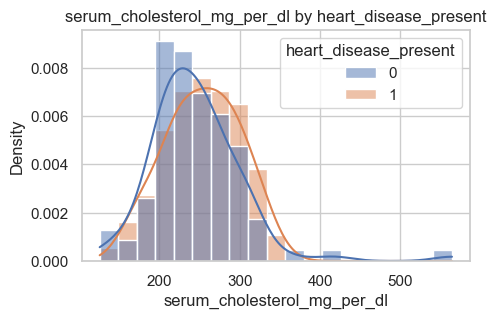

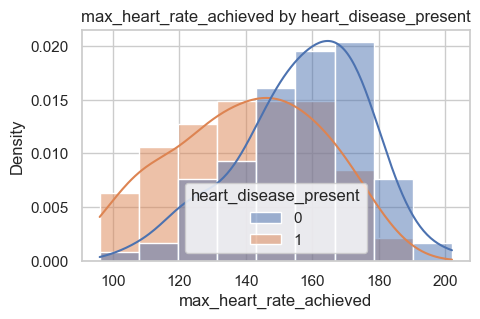

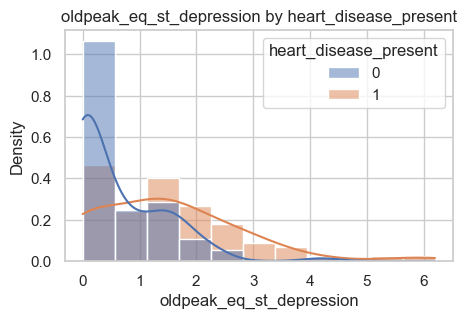

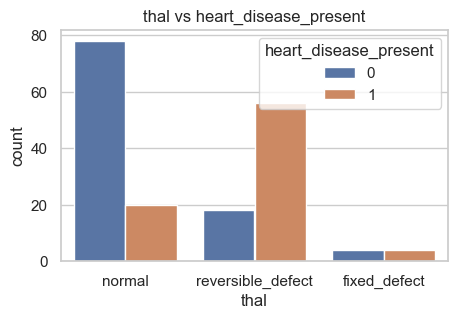

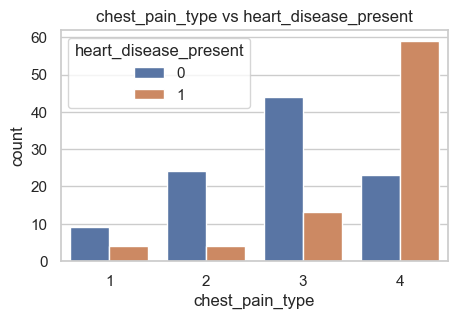

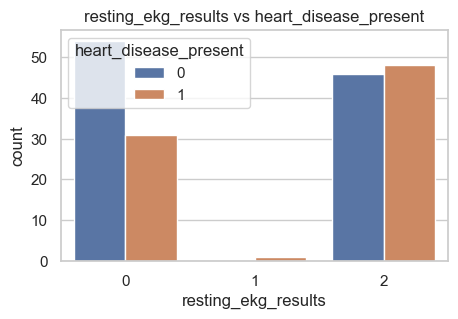

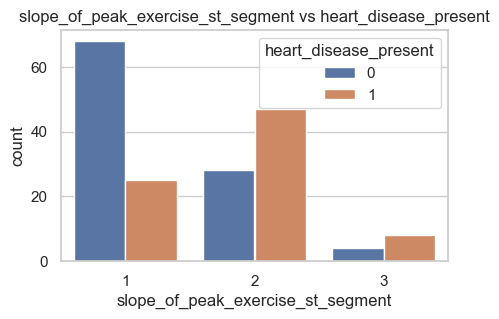

In [7]:
# Basic summary statistics
display(df.describe(include="all"))

# Target distribution plot
plt.figure(figsize=(4, 3))
sns.countplot(x=target_col, data=df)
plt.title("Target distribution: heart_disease_present")
plt.show()

# Continuous features for histograms / KDE
cont_cols = [
    "age",
    "resting_blood_pressure",
    "serum_cholesterol_mg_per_dl",
    "max_heart_rate_achieved",
    "oldpeak_eq_st_depression",
]

for col in cont_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(
        data=df,
        x=col,
        hue=target_col,
        kde=True,
        stat="density",
        common_norm=False
    )
    plt.title(f"{col} by heart_disease_present")
    plt.show()

# Categorical features: counts by class
cat_cols = [
    "thal",
    "chest_pain_type",
    "resting_ekg_results",
    "slope_of_peak_exercise_st_segment",
]

for col in cat_cols:
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x=col, hue=target_col)
    plt.title(f"{col} vs heart_disease_present")
    plt.show()

### Section 4 – Feature lists and preprocessing pipeline

In [8]:
numeric_features = [
    "age",
    "resting_blood_pressure",
    "serum_cholesterol_mg_per_dl",
    "max_heart_rate_achieved",
    "oldpeak_eq_st_depression",
    "num_major_vessels",
    "fasting_blood_sugar_gt_120_mg_per_dl",
    "sex",
    "exercise_induced_angina",
]

categorical_features = [
    "thal",
    "chest_pain_type",
    "resting_ekg_results",
    "slope_of_peak_exercise_st_segment",
]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### Section 5 Train/test split and baseline Logistic Regression

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

log_reg_clf.fit(X_train, y_train)

y_pred = log_reg_clf.predict(X_test)
y_proba = log_reg_clf.predict_proba(X_test)[:, 1]

print("=== Baseline Logistic Regression (hold-out test) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

=== Baseline Logistic Regression (hold-out test) ===
Accuracy: 0.8611111111111112
Precision: 0.7619047619047619
Recall: 1.0
F1: 0.8648648648648649
ROC AUC: 0.959375
PR AUC: 0.9480888483936084
Confusion matrix:
 [[15  5]
 [ 0 16]]


### Section 6 Train/test split and baseline Logistic Regression

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]

log_reg_cv_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

cv_scores = cross_validate(log_reg_cv_clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("=== Logistic Regression (5-fold CV) ===")
for m in scoring:
    print(
        f"{m}: {cv_scores[f'test_{m}'].mean():.3f} +/- {cv_scores[f'test_{m}'].std():.3f}"
    )

=== Logistic Regression (5-fold CV) ===
accuracy: 0.839 +/- 0.057
precision: 0.831 +/- 0.095
recall: 0.812 +/- 0.056
f1: 0.819 +/- 0.061
roc_auc: 0.882 +/- 0.027
average_precision: 0.884 +/- 0.034


### Section 7: Multi-model comparison with cross-validation

In [11]:
models = {
    "log_reg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "rf": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ),
    "xgb": XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=RANDOM_STATE
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc", "average_precision"]

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    summary = {m: scores[f"test_{m}"].mean() for m in scoring}
    summary["model"] = name
    results.append(summary)

results_df = pd.DataFrame(results).set_index("model")
display(results_df)

,accuracy,precision,recall,f1,roc_auc,average_precision
model,,,,,,
log_reg,0.838889,0.831297,0.8125,0.819167,0.882500,0.884469
rf,0.822222,0.825628,0.7750,0.792127,0.894063,0.884147
xgb,0.827778,0.828992,0.7750,0.796644,0.896250,0.894411


### Section 8: Final XGBoost model (train/test evaluation

=== Final XGBoost (hold-out test) ===
Accuracy: 0.8611111111111112
Precision: 0.7894736842105263
Recall: 0.9375
F1: 0.8571428571428571
ROC AUC: 0.95
PR AUC: 0.9247839833777334
Confusion matrix:
 [[16  4]
 [ 1 15]]


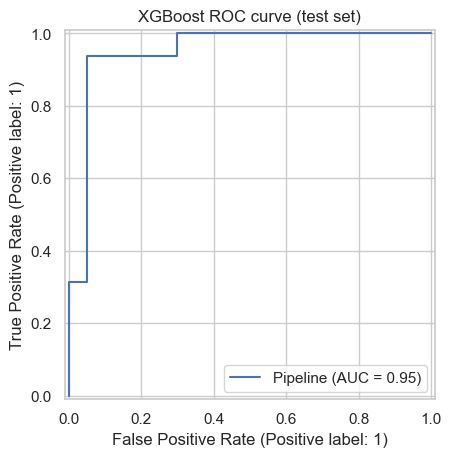

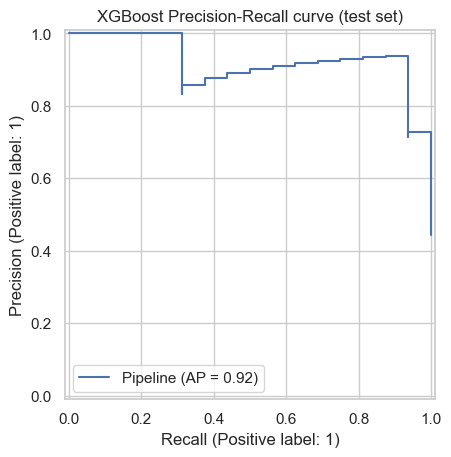

In [14]:

# Use the same hyperparameters you used in Section 7
xgb_final = XGBClassifier(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=RANDOM_STATE
)

xgb_final_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb_final)
])

# Fit on training data only
xgb_final_clf.fit(X_train, y_train)

# Predict on held-out test set
y_pred_xgb = xgb_final_clf.predict(X_test)
y_proba_xgb = xgb_final_clf.predict_proba(X_test)[:, 1]

print("=== Final XGBoost (hold-out test) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("PR AUC:", average_precision_score(y_test, y_proba_xgb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# ROC curve
RocCurveDisplay.from_estimator(xgb_final_clf, X_test, y_test)
plt.title("XGBoost ROC curve (test set)")
plt.show()

# Precision-Recall curve
PrecisionRecallDisplay.from_estimator(xgb_final_clf, X_test, y_test)
plt.title("XGBoost Precision-Recall curve (test set)")
plt.show()

#This mirrors how XGBoost heart‑disease papers report performance: confusion matrix plus ROC and PR curves, with recall being especially important to monitor missed disease

### Section 9: Permutation feature importance (XGBoost pipeline

,feature,importance_mean,importance_std
1,thal,0.100625,0.039598
4,num_major_vessels,0.057604,0.019907
3,chest_pain_type,0.051562,0.022328
8,oldpeak_eq_st_depression,0.039062,0.015703
10,age,0.034583,0.020106
7,serum_cholesterol_mg_per_dl,0.022187,0.010985
9,sex,0.019583,0.017304
0,slope_of_peak_exercise_st_segment,0.014792,0.009338
6,resting_ekg_results,0.010937,0.007206
2,resting_blood_pressure,0.009375,0.006894


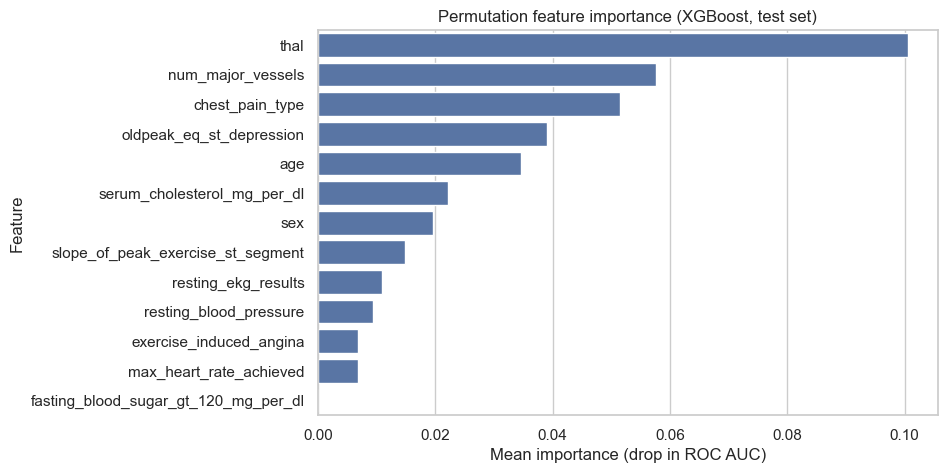

In [19]:
# Use the fitted final XGBoost pipeline and the test set
r = permutation_importance(
    xgb_final_clf,
    X_test,
    y_test,
    n_repeats=30,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="roc_auc"  # importance measured by drop in ROC AUC
)

importances_mean = r.importances_mean
importances_std = r.importances_std

feature_names = X.columns  # original feature names

fi_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance_mean": importances_mean,
        "importance_std": importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

display(fi_df)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=fi_df,
    x="importance_mean",
    y="feature"
)
plt.title("Permutation feature importance (XGBoost, test set)")
plt.xlabel("Mean importance (drop in ROC AUC)")
plt.ylabel("Feature")
plt.show()


# Permutation importance is recommended when using pipelines and mixed numeric/categorical data, and it avoids some biases of tree impurity‑based feature importance.